In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r "/content/drive/My Drive/recurrent-transformer-models/model_artifacts/VanillaTransformer_VanillaTransformer___VanillaModelConfig_max_length_512__vocab_size_50304__n_layer_8__num_heads_8__hidden_dim_768__dropout_0_1__device_device_type__cuda____VanillaTransformer_best_model.pth" "VanillaTransformer_VanillaTransformer___VanillaModelConfig_max_length_512__vocab_size_50304__n_layer_8__num_heads_8__hidden_dim_768__dropout_0_1__device_device_type__cuda____VanillaTransformer_best_model.pth"

In [3]:
!rm -rf Recurrent-Neuron-Transformer

In [4]:
!git clone -b add-dev-container-debug-and-run-name https://github.com/ChrisHayduk/Recurrent-Neuron-Transformer.git

Cloning into 'Recurrent-Neuron-Transformer'...
remote: Enumerating objects: 698, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 698 (delta 186), reused 165 (delta 108), pack-reused 448
Receiving objects: 100% (698/698), 27.82 MiB | 10.27 MiB/s, done.
Resolving deltas: 100% (443/443), done.


In [5]:
!cd Recurrent-Neuron-Transformer/ && pip install -r requirements.txt

In [6]:
import numpy as np
import math
import torch
from torch import nn
import random
import torch.functional as F
from dataclasses import dataclass

@dataclass
class VanillaModelConfig:
    max_length: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    num_heads: int = 12
    hidden_dim: int = 768
    dropout: float = 0.0
    device: str = "cuda"

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.c_fc = nn.Linear(config.hidden_dim, 4 * config.hidden_dim)

        self.gelu = nn.GELU()

        self.c_proj = nn.Linear(4 * config.hidden_dim, config.hidden_dim)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x =  self.c_fc(x)

        x = self.gelu(x)

        x =  self.c_proj(x)

        x = self.dropout(x)

        return x

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.hidden_dim % config.num_heads == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.hidden_dim, 3 * config.hidden_dim)

        # output projection
        self.c_proj = nn.Linear(config.hidden_dim, config.hidden_dim)

        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        self.n_head = config.num_heads
        self.n_embd = config.hidden_dim
        self.dropout = config.dropout
        self.max_length = config.max_length

        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(self.max_length, self.max_length))
                                        .view(1, 1, self.max_length, self.max_length))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        proj_output = self.c_attn(x)

        q, k, v = proj_output.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)

        y = self.resid_dropout(y)
        return y

class TransformerBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.hidden_dim)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.hidden_dim)
        self.mlp = MLP(config)

    def forward(self, x):
        new_x = self.attn(self.ln_1(x))
        x = x + new_x
        new_x = self.mlp(self.ln_2(x))
        x = x + new_x
        return x

class VanillaTransformer(nn.Module):
    """
    A single-layer Transformer which encodes a sequence of text and
    performs binary classification.

    The model has a vocab size of V, works on
    sequences of length T, has an hidden dimension of H, uses word vectors
    also of dimension H, and operates on minibatches of size N.
    """
    def __init__(self, config):
        """
        :config
        """
        super(VanillaTransformer, self).__init__()
        assert config.hidden_dim % config.num_heads == 0

        print(config)

        self.num_heads = config.num_heads
        self.word_embedding_dim = config.hidden_dim
        self.hidden_dim = config.hidden_dim
        self.max_length = config.max_length
        self.vocab_size = config.vocab_size
        self.device = config.device
        self.dropout = config.dropout

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(self.vocab_size, self.word_embedding_dim),
            wpe = nn.Embedding(self.max_length, self.word_embedding_dim),
            drop = nn.Dropout(self.dropout),
            h = nn.ModuleList([TransformerBlock(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(self.hidden_dim),
        ))


        self.lm_head = nn.Linear(self.hidden_dim, self.vocab_size)

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("Number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, inputs):
        """
        This function computes the full Transformer forward pass.
        Put together all of the layers you've developed in the correct order.

        :param inputs: a PyTorch tensor of shape (N,T). These are integer lookups.

        :returns: the model outputs. Should be scores of shape (N,T,output_size).
        """

        embeddings = self.embed(inputs)
        x = self.transformer.drop(embeddings)
        for idx, block in enumerate(self.transformer.h):
            x = block(x)
        x = self.transformer.ln_f(x)
        outputs = self.lm_head(x)


        return outputs


    def embed(self, inputs):
        """
        :param inputs: intTensor of shape (N,T)
        :returns embeddings: floatTensor of shape (N,T,H)
        """

        pos = torch.arange(0, self.max_length, dtype=torch.long, device=self.device) # shape (t)
        tok_emb = self.transformer.wte(inputs) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings  = tok_emb + pos_emb

        return embeddings

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, hidden_layers = None, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, hidden_layers = self(idx_cond, hidden_layers)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import tiktoken
import os

class TextDataset(Dataset):
    def __init__(self, tokens, seq_length, bpe_tokenizer, vocab_size, device):
        self.tokens = tokens
        self.tokenizer = tiktoken.get_encoding(bpe_tokenizer)
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.device = device

    def __len__(self):
        return len(self.tokens) - self.seq_length - 1

    def __getitem__(self, idx):
        input_seq = torch.tensor(self.tokens[idx : idx+self.seq_length], device=self.device)
        target_seq = torch.tensor(self.tokens[idx+1 : idx+1+self.seq_length], device=self.device)
        return input_seq, target_seq


class TextDataLoader:
    def __init__(self, file_path, seq_length, bpe_tokenizer, batch_size, vocab_size, device, split_ratio=0.8):
        self.file_path = file_path
        self.seq_length = seq_length
        self.bpe_tokenizer = bpe_tokenizer
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.device = device
        self.split_ratio = split_ratio

    def load_and_tokenize(self):
        try:
            with open(self.file_path, 'r', encoding='utf-8') as f:
                text = f.read()
            return text
        except IOError:
            print(f"Error opening/reading {self.file_path}")
            return None

    def _create_datasets(self):
        text = self.load_and_tokenize()
        tokenizer = tiktoken.get_encoding(self.bpe_tokenizer)
        tokens = tokenizer.encode_ordinary(text)
        split_index = int(len(tokens) * self.split_ratio)
        train_tokens = tokens[:split_index]
        test_tokens = tokens[split_index:]
        train_dataset = TextDataset(train_tokens, self.seq_length, self.bpe_tokenizer, self.vocab_size, self.device)
        test_dataset = TextDataset(test_tokens, self.seq_length, self.bpe_tokenizer, self.vocab_size, self.device)
        return train_dataset, test_dataset

    def create_loaders(self):
        train_dataset, test_dataset = self._create_datasets()
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
        return train_loader, test_loader


In [8]:
# Device configuration
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [9]:
model_config = VanillaModelConfig(max_length=512, vocab_size=50304,
                                    n_layer=8, num_heads=8, hidden_dim=768,
                                    dropout=0.1, device=DEVICE)

model = VanillaTransformer(config=model_config).to(DEVICE)

VanillaModelConfig(max_length=512, vocab_size=50304, n_layer=8, num_heads=8, hidden_dim=768, dropout=0.1, device=device(type='cuda'))
Number of parameters: 134.02M


In [10]:
model.load_state_dict(torch.load('VanillaTransformer_VanillaTransformer___VanillaModelConfig_max_length_512__vocab_size_50304__n_layer_8__num_heads_8__hidden_dim_768__dropout_0_1__device_device_type__cuda____VanillaTransformer_best_model.pth'))

<All keys matched successfully>

In [11]:
data_loader = TextDataLoader(file_path="Recurrent-Neuron-Transformer/data/shakespeare/tinyshakespeare.txt",
                             seq_length=4096,
                             bpe_tokenizer='gpt2',
                             batch_size=12,
                             vocab_size=50304,
                             split_ratio=0.8,
                             device=DEVICE)
train_loader, test_loader = data_loader.create_loaders()

In [12]:
def transformer_forward(model, input_seq, target_seq):
    # Forward pass
    outputs = model(input_seq)
    outputs = outputs.reshape(-1, outputs.size(-1))
    target_seq = target_seq.reshape(-1)

    # Calculate loss and backpropagate
    loss = nn.CrossEntropyLoss()(outputs, target_seq)

    return outputs, loss

In [13]:
import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="transformer-testing",
)

wandb.run.name = "Vanilla-Model-Stepwise-eval"
wandb.define_metric("epoch")
wandb.define_metric("eval_batch")

wandb.define_metric("epoch/*", step_metric="epoch")
wandb.define_metric("eval_batch/*", step_metric="eval_batch")



wandb: Currently logged in as: chayduk (recurrent-neuron-transformer). Use `wandb login --relogin` to force relogin


In [14]:
from tqdm import tqdm

context_window = 512
step_size = 511
distributed = False
rank = 0


model.eval()
epoch_val_loss = 0
eval_progress_bar = tqdm(test_loader, desc=f'Evaluating: Epoch 1', leave=False)
num_steps = (4096/511)

if int(num_steps) < num_steps:
  num_steps = int(num_steps) + 1
else:
  num_steps = int(num_steps)

step_losses = [0] * num_steps
raw_losses = [0] * num_steps
with torch.no_grad():
    for batch_idx, (input_chunk, target_chunk) in enumerate(eval_progress_bar):
        batch_loss = 0
        hidden_layers = dict()

        for i in range(0, input_chunk.size(1) - context_window, step_size):
            index = i//step_size
            # Create the input and target sequences
            input_seq = input_chunk[:, i:i+context_window].to(DEVICE)
            target_seq = target_chunk[:, i+1:i+context_window+1].to(DEVICE)

            outputs = None
            loss = None
            outputs, loss = transformer_forward(model, input_seq, target_seq)

            batch_loss += loss.item()

            raw_losses[index] += loss.item()

            step_losses[index] = raw_losses[index] / (batch_idx + 1)

            if (rank == 0 or not distributed):
                wandb.log({'eval_batch': batch_idx, f'eval_batch/step_{index}_loss': loss.item()})
                wandb.log({'eval_batch': batch_idx, f'eval_batch/step_{index}_average_loss': step_losses[index]})

        epoch_val_loss += batch_loss
        eval_progress_bar.set_postfix(loss=batch_loss)

avg_val_loss = epoch_val_loss / len(test_loader)

wandb.log({'epoch': 1, 'epoch/val_loss': avg_val_loss})


In [15]:
torch.cuda.empty_cache()

In [ ]:
vanilla_transformer_losses = [14.318, 14.326, 14.327, 14.326, 14.339, 14.352, 14.367, 14.383]
recurrent_neuron_transformer_losses = [17.953, 17.988, 17.963, 17.944, 17.946, 17.969, 17.992, 18.011]
steps = [0, 1, 2, 3, 4, 5, 6, 7]

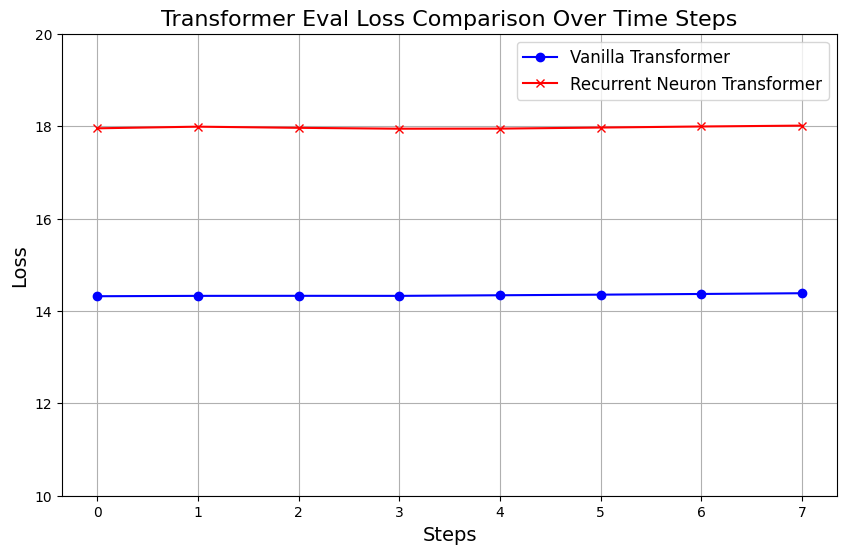

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Data preparation
vanilla_transformer_losses = [14.318, 14.326, 14.327, 14.326, 14.339, 14.352, 14.367, 14.383]
recurrent_neuron_transformer_losses = [17.953, 17.988, 17.963, 17.944, 17.946, 17.969, 17.992, 18.011]
steps = [0, 1, 2, 3, 4, 5, 6, 7]

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting both sets of loss values
plt.plot(steps, vanilla_transformer_losses, label='Vanilla Transformer', color='blue', marker='o')
plt.plot(steps, recurrent_neuron_transformer_losses, label='Recurrent Neuron Transformer', color='red', marker='x')

# Styling and customization
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Transformer Eval Loss Comparison Over Time Steps', fontsize=16)
plt.legend(fontsize=12)

# Adding grid for better readability
plt.grid(True)

# Setting y-axis limits
plt.ylim(10, 20)

# Customizing the x-axis to show integer steps
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Save the plot with a high DPI for better quality in papers and presentations
plt.savefig('transformer_loss_comparison.png', dpi=300)

# Show the plot
plt.show()
